In [3]:
from pathlib import Path
from tqdm import tqdm
import polars as pl
from polars import col
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = Path.home() / 'OneDrive - Seagroup/ai/kaggle_dataset/child-mind-institute-detect-sleep-states'
df = (
    pl.read_parquet(path / 'clean.parquet')
)
df.head()

series_id,step,anglez,enmo,timestamp,is_wakeup
str,i32,f32,f32,datetime[μs],i32
"""038441c925bb""",0,2.6367,0.0217,2018-08-14 19:30:00,null
"""038441c925bb""",1,2.6368,0.0215,2018-08-14 19:30:05,null
"""038441c925bb""",2,2.637,0.0216,2018-08-14 19:30:10,null
"""038441c925bb""",3,2.6368,0.0213,2018-08-14 19:30:15,null
"""038441c925bb""",4,2.6368,0.0215,2018-08-14 19:30:20,null


In [5]:
series_id = '1716cd4163b2'

tmp = (
    df.filter(col('series_id') == series_id)
    .with_columns(col('timestamp').shift(1).over(['series_id', 'is_wakeup']).backward_fill().alias('previous_timestamp'))
    .with_columns((col('timestamp') - col('previous_timestamp')).dt.seconds().alias('duration'))
    .with_columns(col('duration').cumsum().over(['series_id', 'is_wakeup']).alias('roll_sum'))
    # .filter(col('step').is_between(4810, 4820))
)

change = 0
i = 0
output = [0]
for idx, value in tqdm(enumerate(tmp['is_wakeup'][1:]), total=len(tmp['is_wakeup'][1:])):
    if value != tmp['is_wakeup'][idx]:
        change += 1
        if change % 2 == 0:
            i += 1
    output.append(i)

tmp = tmp.with_columns(pl.Series(output).alias('tag'))
tmp.head()

100%|██████████| 478799/478799 [00:00<00:00, 894579.70it/s]


series_id,step,anglez,enmo,timestamp,is_wakeup,previous_timestamp,duration,roll_sum,tag
str,i32,f32,f32,datetime[μs],i32,datetime[μs],i64,i64,i64
"""1716cd4163b2""",0,0.3814,0.0305,2019-05-03 16:30:00,1,2019-05-03 16:30:00,0,0,0
"""1716cd4163b2""",1,-12.5609,0.0538,2019-05-03 16:30:05,1,2019-05-03 16:30:00,5,5,0
"""1716cd4163b2""",2,-10.3136,0.0438,2019-05-03 16:30:10,1,2019-05-03 16:30:05,5,10,0
"""1716cd4163b2""",3,-8.1462,0.0497,2019-05-03 16:30:15,1,2019-05-03 16:30:10,5,15,0
"""1716cd4163b2""",4,32.202099,0.0305,2019-05-03 16:30:20,1,2019-05-03 16:30:15,5,20,0


In [11]:
tmp.filter(col('tag') == 1)['timestamp'].min(), tmp.filter(col('tag') == 1)['timestamp'].max()

(datetime.datetime(2019, 5, 4, 12, 30),
 datetime.datetime(2019, 5, 5, 13, 17, 55))

In [12]:
tmp.filter(col('tag') == 1)

series_id,step,anglez,enmo,timestamp,is_wakeup,previous_timestamp,duration,roll_sum,tag
str,i32,f32,f32,datetime[μs],i32,datetime[μs],i64,i64,i64
"""1716cd4163b2""",14400,21.2279,0.0011,2019-05-04 12:30:00,1,2019-05-04 02:55:55,34445,72000,1
"""1716cd4163b2""",14401,22.864799,0.0,2019-05-04 12:30:05,1,2019-05-04 12:30:00,5,72005,1
"""1716cd4163b2""",14402,22.803801,0.0,2019-05-04 12:30:10,1,2019-05-04 12:30:05,5,72010,1
"""1716cd4163b2""",14403,23.6752,0.0,2019-05-04 12:30:15,1,2019-05-04 12:30:10,5,72015,1
"""1716cd4163b2""",14404,23.9004,0.0,2019-05-04 12:30:20,1,2019-05-04 12:30:15,5,72020,1
"""1716cd4163b2""",14405,24.070499,0.0,2019-05-04 12:30:25,1,2019-05-04 12:30:20,5,72025,1
"""1716cd4163b2""",14406,24.479601,0.0,2019-05-04 12:30:30,1,2019-05-04 12:30:25,5,72030,1
"""1716cd4163b2""",14407,24.348801,0.0,2019-05-04 12:30:35,1,2019-05-04 12:30:30,5,72035,1
"""1716cd4163b2""",14408,22.7976,0.0,2019-05-04 12:30:40,1,2019-05-04 12:30:35,5,72040,1


<Axes: xlabel='timestamp', ylabel='enmo'>

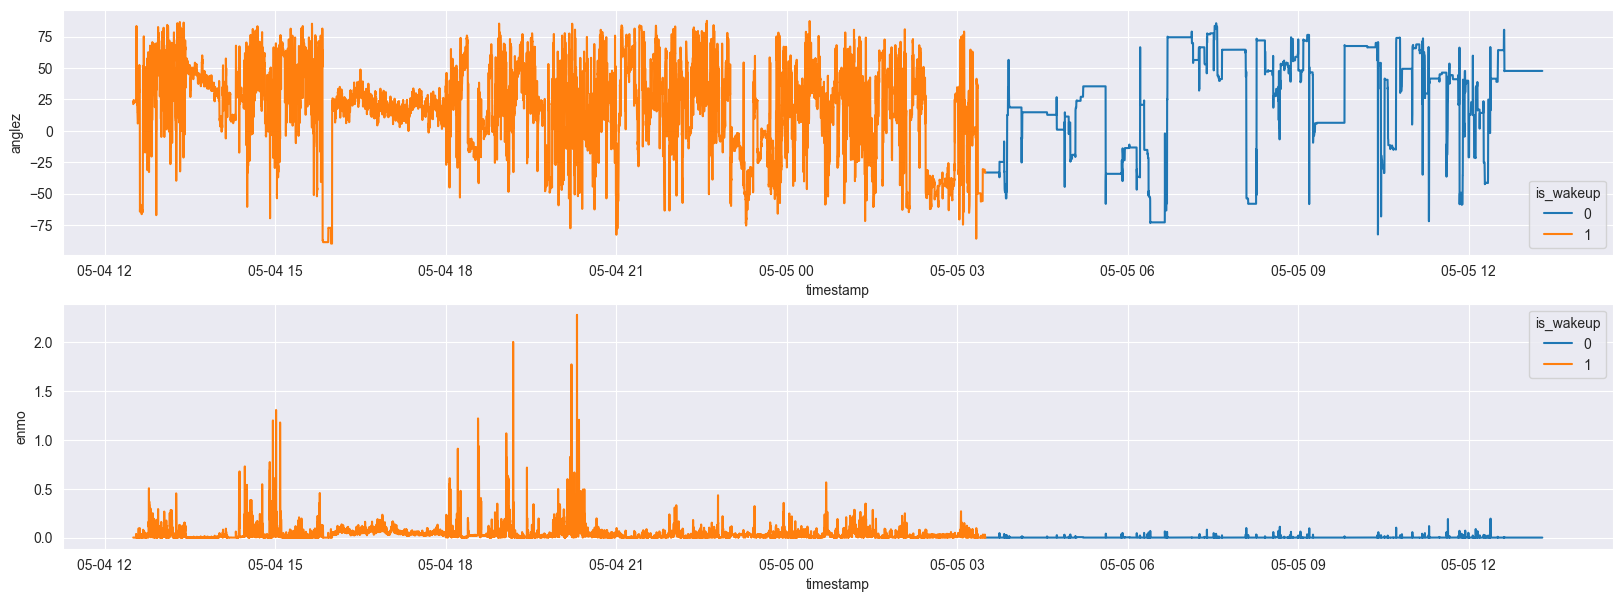

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(20, 7))
axes = axes.flatten()
sns.lineplot(data=tmp.filter(col('tag') == 1), x='timestamp', y='anglez', hue='is_wakeup', ax=axes[0])
sns.lineplot(data=tmp.filter(col('tag') == 1), x='timestamp', y='enmo', hue='is_wakeup', ax=axes[1])

In [21]:
duration = (
    tmp.groupby(['series_id', 'tag', 'is_wakeup'], maintain_order=True).agg(
        col('duration').sum(),
        col('timestamp').max().alias('max_timestamp'),
        col('timestamp').min().alias('min_timestamp'),
    )
    .with_columns((col('duration') / 3600).alias('duration_hour'))
)
duration

series_id,tag,is_wakeup,duration,max_timestamp,duration_hour
str,i64,i32,i64,datetime[μs],f64
"""1716cd4163b2""",0,1,37555,2019-05-04 02:55:55,10.431944
"""1716cd4163b2""",0,0,34435,2019-05-04 12:29:55,9.565278
"""1716cd4163b2""",1,1,88440,2019-05-05 03:29:55,24.566667
"""1716cd4163b2""",1,0,89280,2019-05-05 13:17:55,24.8
"""1716cd4163b2""",2,1,80580,2019-05-06 01:52:55,22.383333
"""1716cd4163b2""",2,0,78120,2019-05-06 10:59:55,21.7
"""1716cd4163b2""",3,1,85680,2019-05-07 01:40:55,23.8
"""1716cd4163b2""",3,0,86760,2019-05-07 11:05:55,24.1
"""1716cd4163b2""",4,1,84720,2019-05-08 01:12:55,23.533333


<Axes: xlabel='tag', ylabel='duration_hour'>

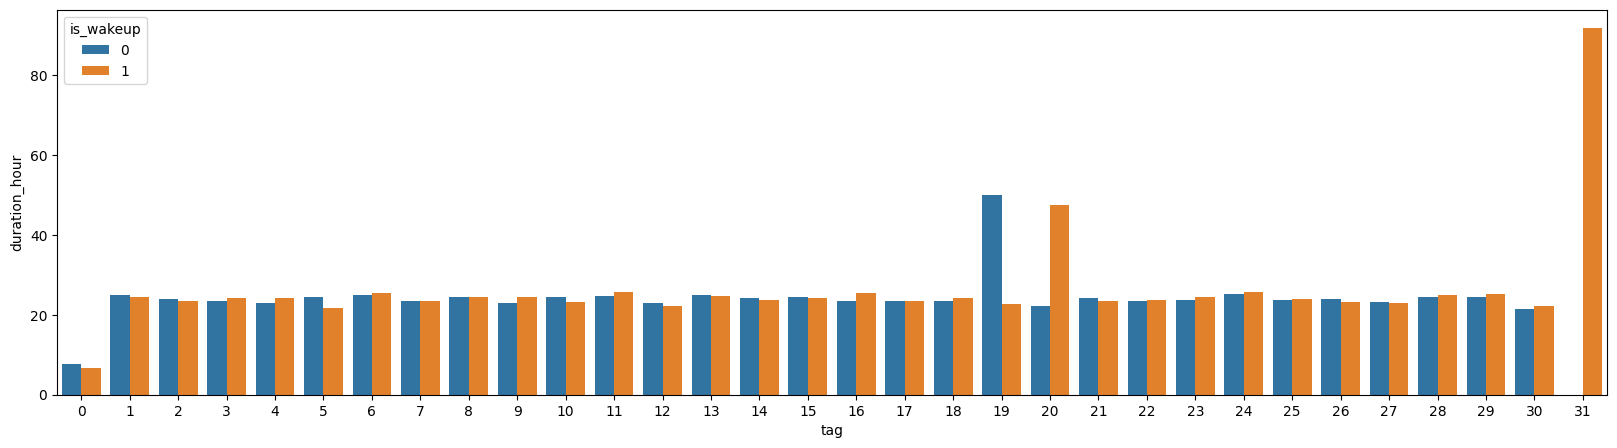

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(data=duration.to_pandas(), x='tag', y='duration_hour', hue='is_wakeup', ax=ax)
fig.suptitle(f'series id {series_id}', fontsize=16)
fig.tight_layout()

fig.savefig(path / f'media/duration/{series_id}.png', dpi=300)
plt.close('all')
plt.close(fig)

In [158]:
tmp.filter(col('tag') == 0)

series_id,step,anglez,enmo,timestamp,is_wakeup,grass_date,grass_hour,previous_timestamp,duration,roll_sum,tag
str,i32,f32,f32,datetime[μs],i32,str,str,datetime[μs],i64,i64,i64
"""0ce74d6d2106""",0,16.8396,0.1859,2017-08-21 20:30:00,1,"""2017-08-21""","""20:30:00""",2017-08-21 20:30:00,0,0,0
"""0ce74d6d2106""",1,10.8135,0.0132,2017-08-21 20:30:05,1,"""2017-08-21""","""20:30:05""",2017-08-21 20:30:00,5,5,0
"""0ce74d6d2106""",2,-11.6835,0.0471,2017-08-21 20:30:10,1,"""2017-08-21""","""20:30:10""",2017-08-21 20:30:05,5,10,0
"""0ce74d6d2106""",3,-17.6252,0.0361,2017-08-21 20:30:15,1,"""2017-08-21""","""20:30:15""",2017-08-21 20:30:10,5,15,0
"""0ce74d6d2106""",4,-7.5291,0.0287,2017-08-21 20:30:20,1,"""2017-08-21""","""20:30:20""",2017-08-21 20:30:15,5,20,0
"""0ce74d6d2106""",5,-14.9823,0.0268,2017-08-21 20:30:25,1,"""2017-08-21""","""20:30:25""",2017-08-21 20:30:20,5,25,0
"""0ce74d6d2106""",6,-16.738001,0.0551,2017-08-21 20:30:30,1,"""2017-08-21""","""20:30:30""",2017-08-21 20:30:25,5,30,0
"""0ce74d6d2106""",7,19.3197,0.0345,2017-08-21 20:30:35,1,"""2017-08-21""","""20:30:35""",2017-08-21 20:30:30,5,35,0
"""0ce74d6d2106""",8,61.326401,0.0095,2017-08-21 20:30:40,1,"""2017-08-21""","""20:30:40""",2017-08-21 20:30:35,5,40,0


In [159]:
tmp.filter(col('tag') == 0).groupby('is_wakeup').agg(col('timestamp').max())

is_wakeup,timestamp
i32,datetime[μs]
0,2017-08-22 10:51:55
1,2017-08-22 03:10:55


In [160]:
tmp.filter(col('tag') == 0).groupby('is_wakeup').agg(col('timestamp').min())

is_wakeup,timestamp
i32,datetime[μs]
0,2017-08-22 03:11:00
1,2017-08-21 20:30:00


In [1]:
a = [2, 2, 2, 3, 3, 3, 4, 4, 2, 3, 3, 4, 2, 2, 3, 3, 4, 4, 4]
group = []
stt = 0
end = 0
for i in range(0, len(a)):
    lst = a[end:i]
    current = a[i]
    prev = a[i-1]
    if set(lst) < {2, 3, 4} or current == prev:
        group.append(stt)
    else:
        stt+=1
        group.append(stt)
        end = len(group) - 1
print(group)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]


In [2]:
_output = {
    'a': [2, 2, 2, 3, 3, 3, 4, 4, 2, 3, 3, 4, 2, 2, 3, 3, 4, 4, 4], 
    }
change = 0
i = 0
output = [0]
for idx, value in enumerate(_output['a'][1:]):
    if value != _output['a'][idx]:
        change += 1
        if change % 3 == 0:
            i += 1
    output.append(i)
    
print(output)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
